In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Rolling Three-Factor Model

In [17]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.formula.api as smf
import pandas_datareader.data as web

1- Define parameters

In [3]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

2- Download the factor related data

In [10]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

3- Download the prices of risky assets from Yahoo Finance

In [11]:
asset_df = yf.download(ASSETS, start=START_DATE, end=END_DATE)
print(f'Downloaded {asset_df.shape[0]} rows of data.')

[*********************100%%**********************]  4 of 4 completed
Downloaded 2264 rows of data.


4- Calculate the monthly returns on the risky assets

In [12]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()

# Reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

5- Calculate the portfolio returns

In [15]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145230,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042676,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151394,-0.082161


<Axes: xlabel='Date'>

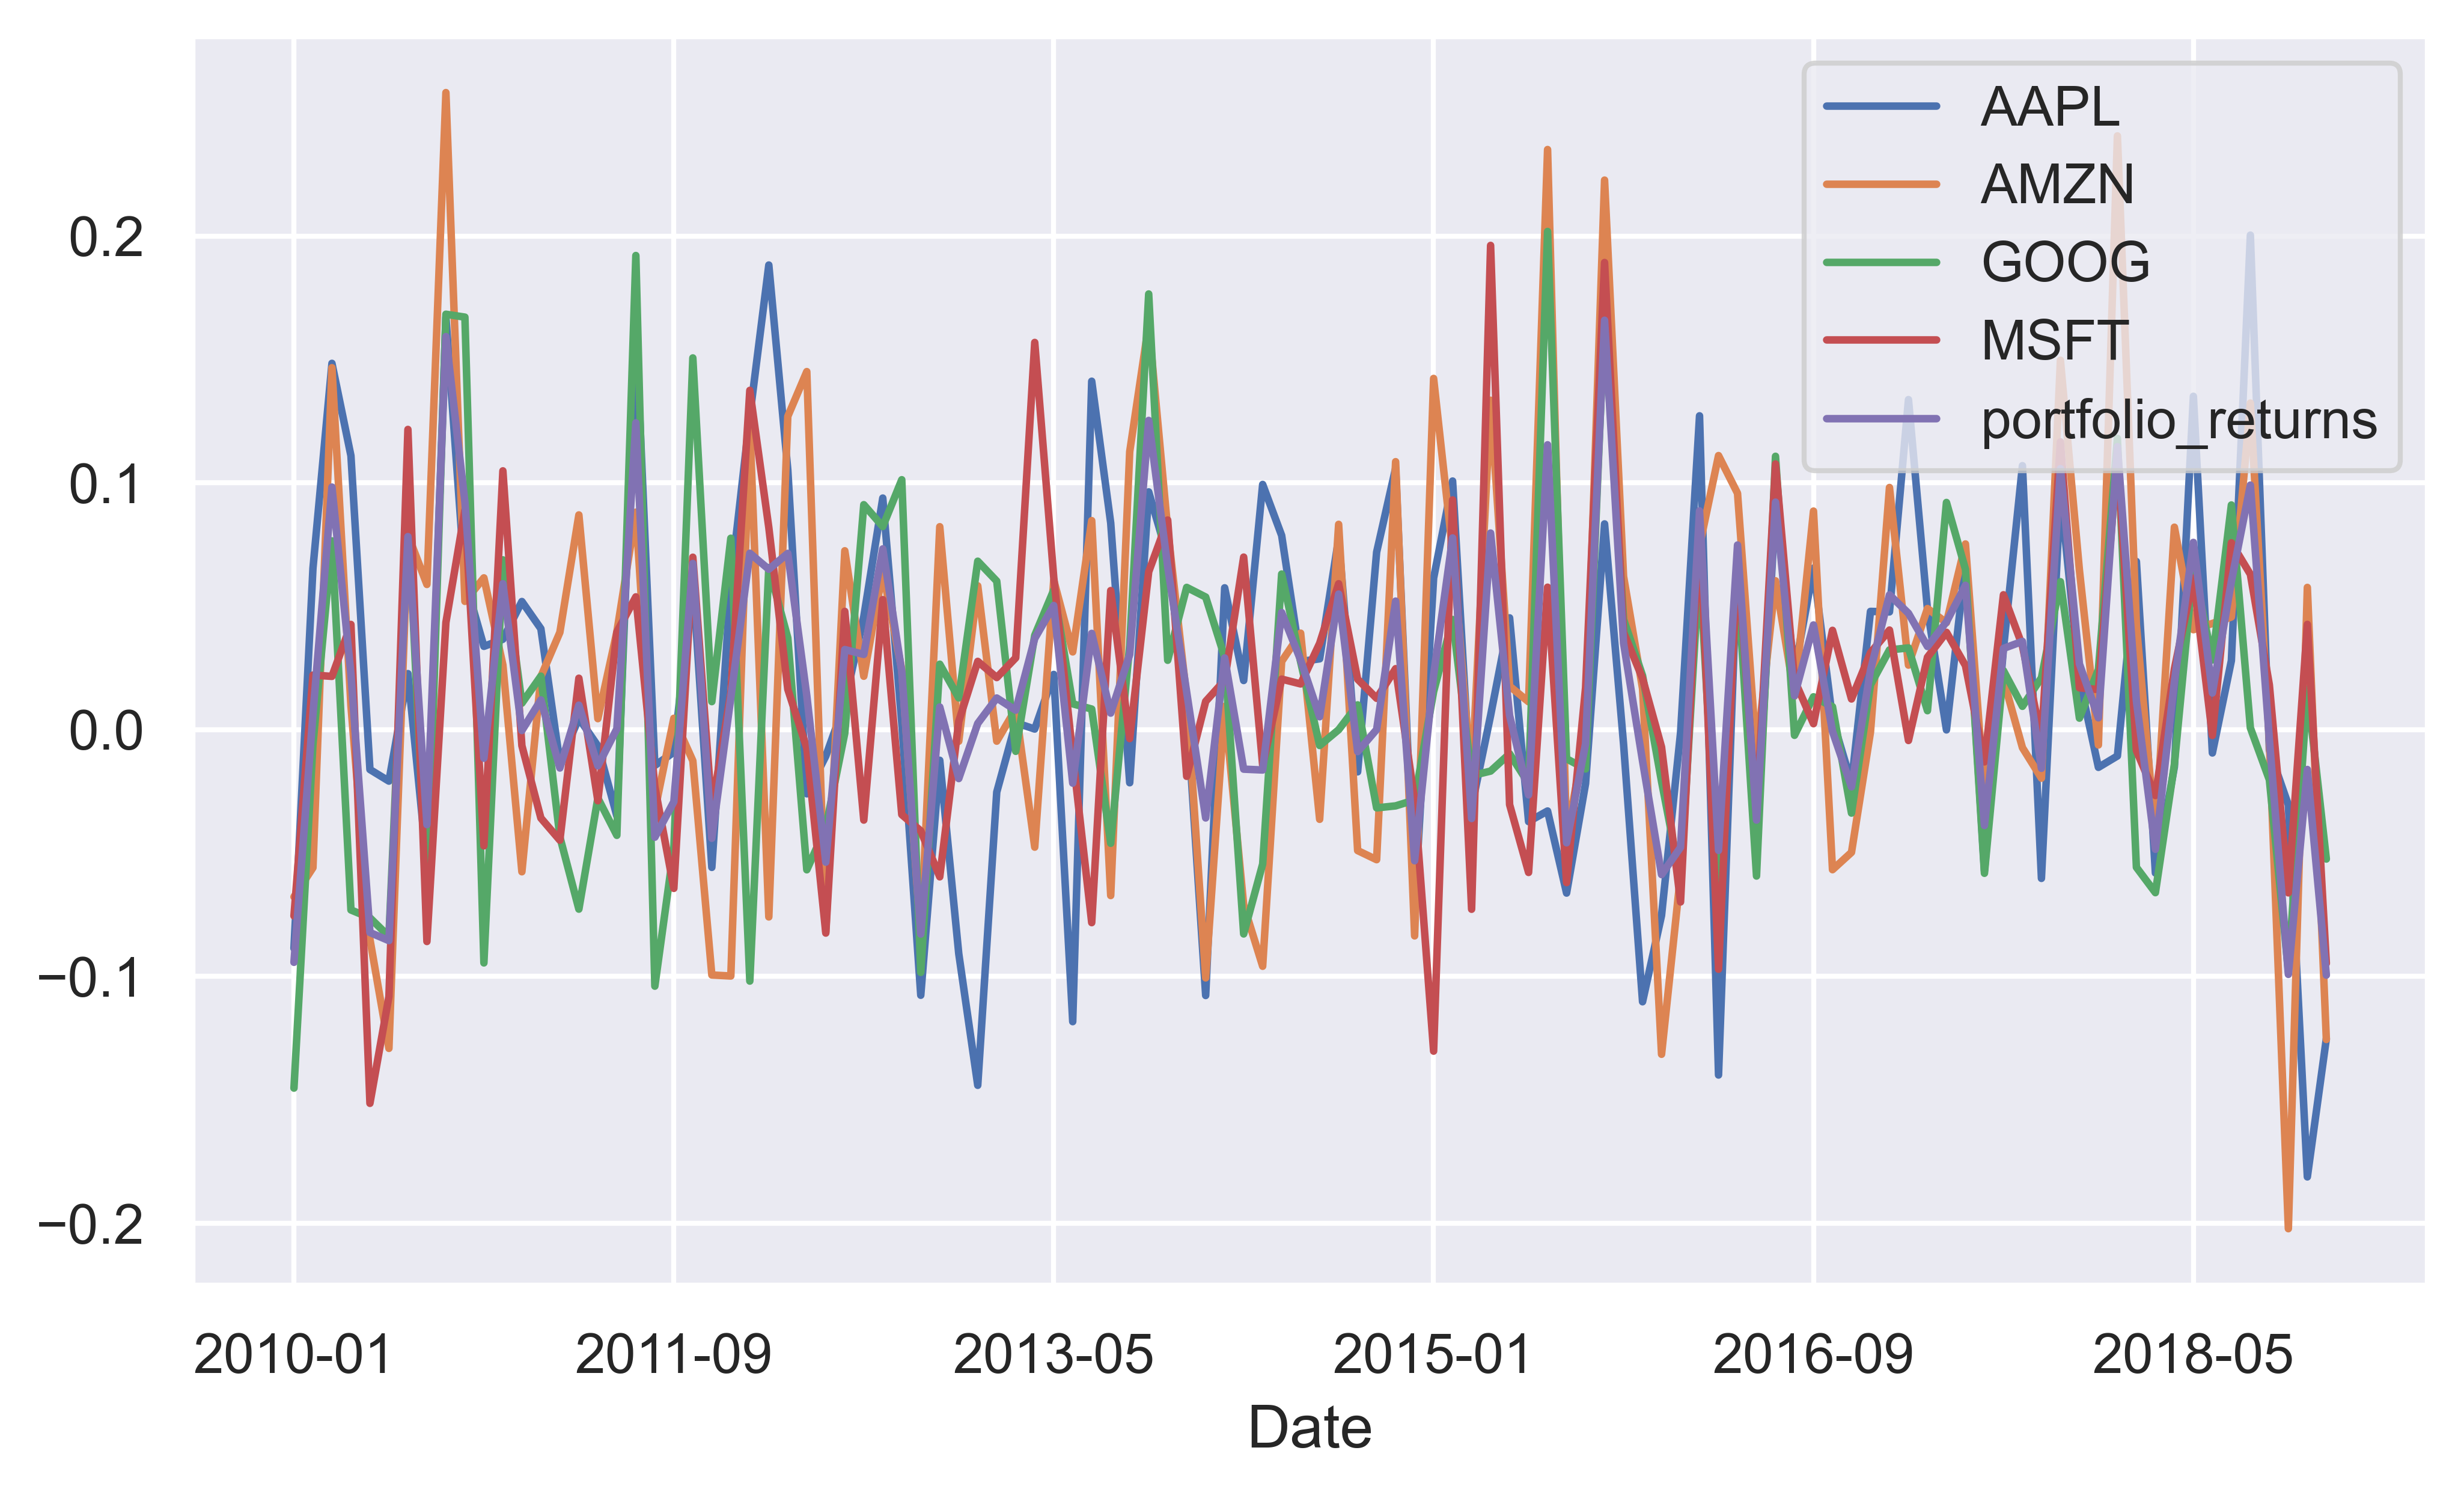

In [20]:
asset_df.plot()

6- Merge the datasets

In [21]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [22]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0040,0.0043,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0323,0.0000,0.006430
2010-03,0.098335,0.0631,0.0148,0.0221,0.0001,0.098235
2010-04,0.022615,0.0200,0.0487,0.0289,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0009,-0.0244,0.0001,-0.082261


7- Define a function for the rolling n-factor model

In [23]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ----------
    input_data : pd.DataFrame
    A DataFrame containing the factors and asset/portfolio returns

    formula : str
    'statsmodels' compatible formula representing the OLS regression

    window_size : int
    Rolling window lenght

    Returns
    -------
    coeffs_df : pd.DataFrame
    DataFrame containing the intercept and the three factors for each iteration
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):
        end_index = start_index + window_size

        # Define and fit the regression model
        ff_model = smf.ols(formula=formula, data=input_data[start_index:end_index]).fit()

        # Store coefficients
        coeffs.append(ff_model.params)

    coeffs_df = pd.DataFrame(coeffs, index=input_data.index[window_size-1:])

    return coeffs_df

8- Estimate the rolling Three-Factor Model and plot the results

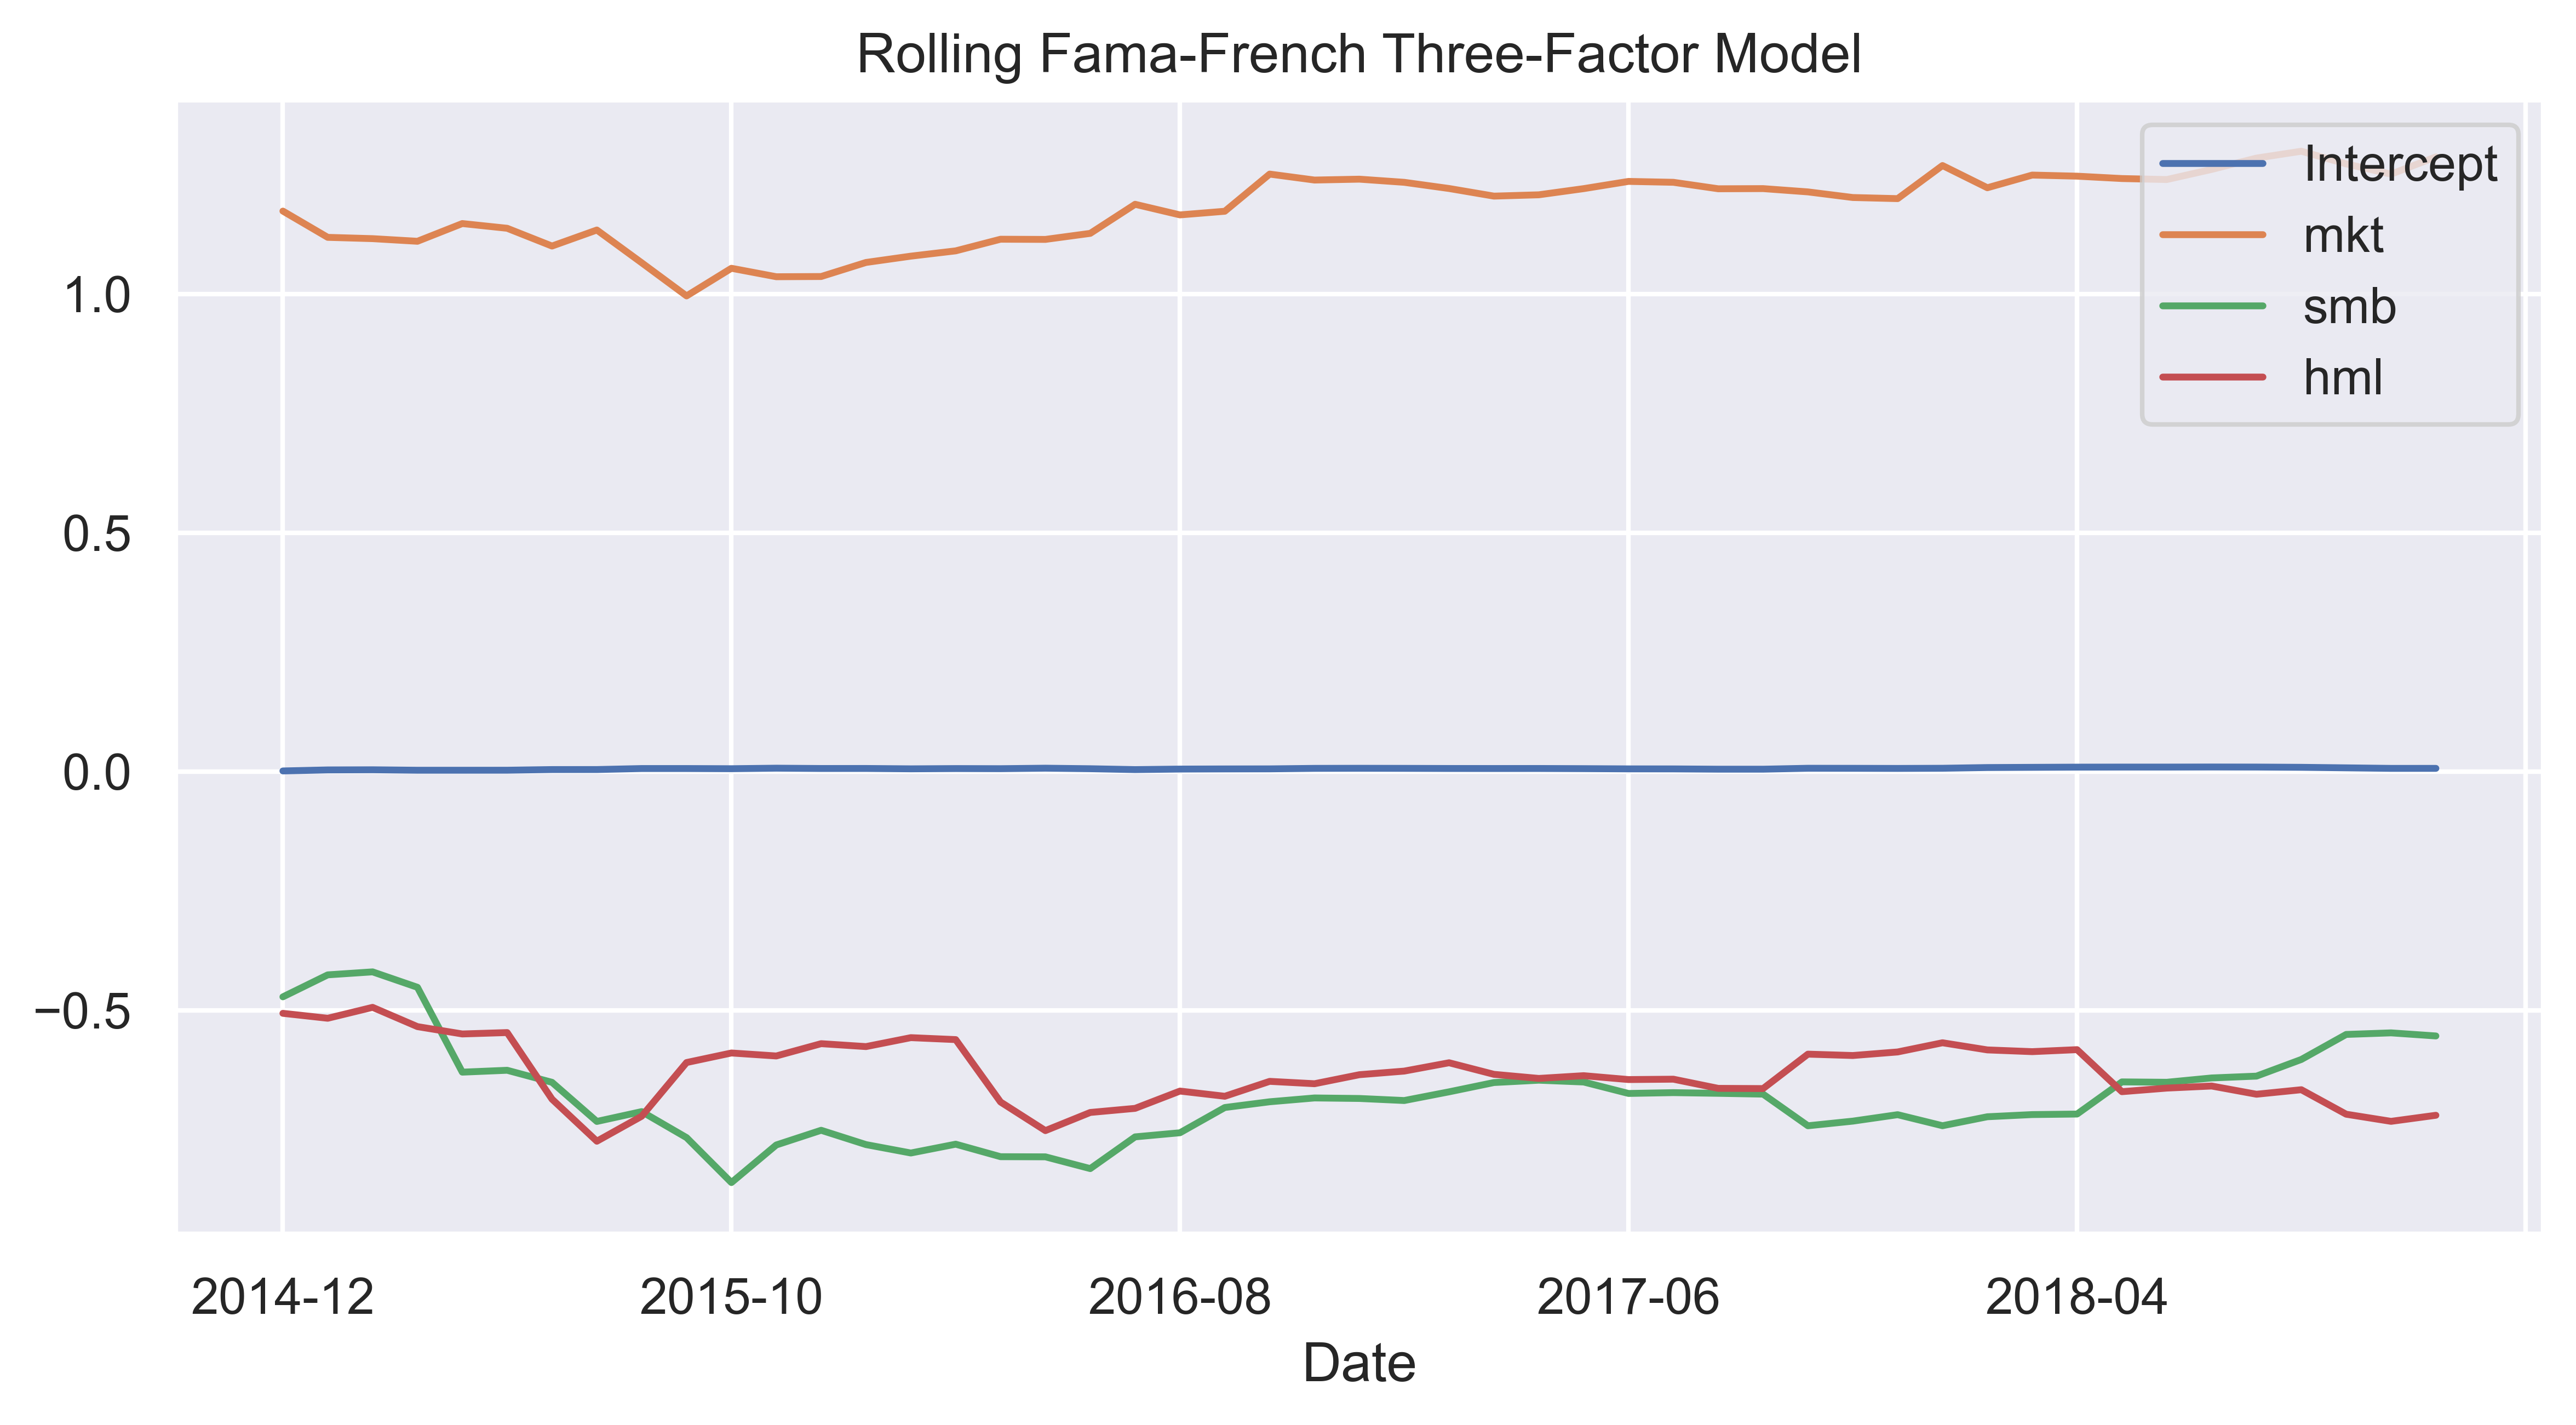

In [24]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, MODEL_FORMULA, window_size=60)
results_df.plot(title='Rolling Fama-French Three-Factor Model')

plt.tight_layout()
plt.show()